In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
df_org = pd.read_csv('data/immo_data.csv')

In [3]:
df_new = df_org[['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent']]

In [4]:
df_new.head()

,serviceCharge,heatingType,telekomUploadSpeed,totalRent
0,245.00,central_heating,10.0,840.0
1,134.00,self_contained_central_heating,10.0,NaN
2,255.00,floor_heating,2.4,1300.0
3,58.15,district_heating,40.0,NaN
4,138.00,self_contained_central_heating,NaN,903.0


In [5]:
df_new.shape

(268850, 4)

In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   serviceCharge       261941 non-null  float64
 1   heatingType         223994 non-null  object 
 2   telekomUploadSpeed  235492 non-null  float64
 3   totalRent           228333 non-null  float64
dtypes: float64(3), object(1)
memory usage: 8.2+ MB


In [7]:
df_new.isna().sum()

serviceCharge          6909
heatingType           44856
telekomUploadSpeed    33358
totalRent             40517
dtype: int64

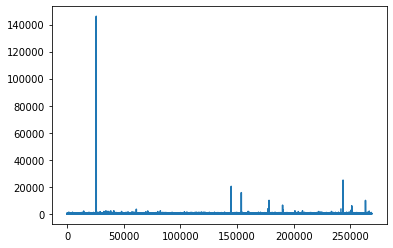

In [8]:
df_new['serviceCharge'].plot()
plt.show()

In [9]:
df_new['serviceCharge'].median()

151.20611301781702

In [1]:
df_new['serviceCharge'].fillna(df_new['serviceCharge'].median(), inplace=True)

NameError: name 'df_new' is not defined

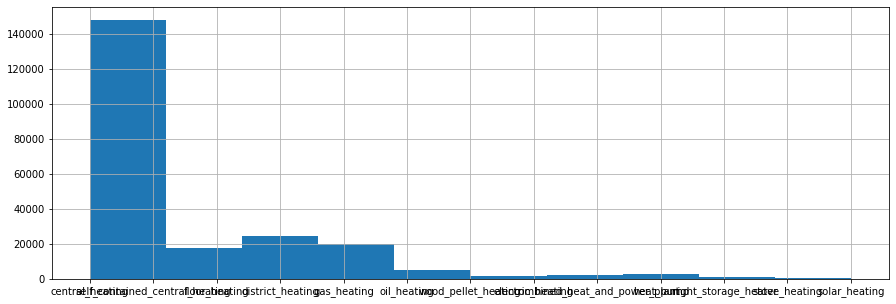

In [11]:
plt.figure(figsize=(15,5))
df_new['heatingType'].hist()
plt.show()

In [12]:
df_new['heatingType'].mode()

0    central_heating
Name: heatingType, dtype: object

In [2]:
df_new['heatingType'].fillna(df_new['heatingType'].mode()[0], inplace=True)

NameError: name 'df_new' is not defined

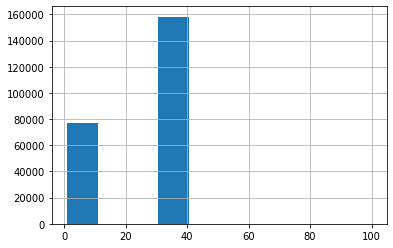

In [14]:
df_new['telekomUploadSpeed'].hist()
plt.show()

In [15]:
df_new['telekomUploadSpeed'].median()

40.0

In [3]:
df_new['telekomUploadSpeed'].fillna(df_new['telekomUploadSpeed'].median(), inplace=True)

NameError: name 'df_new' is not defined

In [4]:
df_new['totalRent'].fillna(df_new['totalRent'].median(), inplace=True)

NameError: name 'df_new' is not defined

In [18]:
df_new.isna().sum()

serviceCharge         0
heatingType           0
telekomUploadSpeed    0
totalRent             0
dtype: int64

In [19]:
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1
kurt = df_new.kurt(numeric_only=True)[:]
kurt

serviceCharge         197151.674512
telekomUploadSpeed        -0.765917
totalRent             260044.391607
dtype: float64

In [20]:
outliers = ['serviceCharge', 'totalRent']

In [21]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [22]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df_org[col])[0])}')

serviceCharge: 0
totalRent: 0


In [23]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [24]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df_org[col])[0])}')

serviceCharge: 96
totalRent: 6


In [55]:
for i in outliers:
    quartile_1, quartile_3 = np.percentile(df_new[i], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df_new = df_new[df_new[i]<upper_bound]
    df_new = df_new[df_new[i]>lower_bound]

In [56]:
X = df_new.drop('totalRent', axis=1)
y = df_new['totalRent']
y = pd.DataFrame(data=y, columns=['totalRent'])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
y_train

,totalRent
5277,900.00
143328,320.00
235859,1235.00
63245,590.00
198872,487.26
...,...
133116,418.90
115164,1331.07
146442,440.00
163084,388.01


In [59]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ss = StandardScaler()

In [60]:
preprocessor_x = ColumnTransformer(
    transformers=[
            ('serviceCharge', ss, ['serviceCharge']),
            ('telekomUploadSpeed', ss, ['telekomUploadSpeed']),
            ('heatingType', ohe, ['heatingType']),       
])
preprocessor_y = ColumnTransformer(
    transformers=[
            ('totalRent', ss, ['totalRent']),       
])

In [61]:
fitter_y = preprocessor_y.fit(y_train)
fitter_x = preprocessor_x.fit(X_train)

In [62]:
y_train = fitter_y.transform(y_train)
y_test = fitter_y.transform(y_test)
X_train = fitter_x.transform(X_train)
X_test = fitter_x.transform(X_test)

In [63]:
m, n = y_train.shape
x, z = y_test.shape
y_train = y_train.reshape(m, )
y_test = y_test.reshape(x, )

In [166]:
# Linear reggression
class Reggression() :   
    def __init__( self, learning_rate=0.01 , iterations=1000 , method='mse') :
        self.learning_rate = learning_rate
        self.iterations = iterations 
        self.method = method

    
    # Function for model training        
    def fit( self, X, Y ) : 
        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape 
        # weight initialization 
        self.W = np.random.normal(loc=0.0, scale=0.001, size=self.n)
        self.b = 0 
        self.X = X
        self.Y = Y 
        # gradient descent learning         
        for i in range( self.iterations ) :
            self.update_weights(X, Y)  
        return self
    
    
    # Helper function to update weights in gradient descent 
    def update_weights( self, X, Y ) :
        Y_pred = self.predict( X )
        # calculate gradients
        
        # Linear reggression with minimum square error
        if self.method == 'mse':
            error = (Y - Y_pred)
            dW = - ( 2 * ( X.T ).dot( error )  ) / self.m
            db = - 2 * np.sum( error ) / self.m
    
            
        # Linear reggression with minimum absolute error
        elif self.method == 'ae':
            error = abs(Y - Y_pred)
            error = np.where(error == 0, 0.01, error)
            dW = -(np.sum( X.T, axis=1)/ self.m)
            db = -np.sum(error) / self.m
            
        
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db 
        return self
    
    # Hypothetical function  h( x )  
    def predict( self, X ) :
        return (X.dot( self.W ) + self.b)

# Linear Reggression with mse

In [145]:
model_mse = Reggression(method='mse')

In [146]:
model_mse.fit(X_train, y_train)

In [147]:
y_pre_test_mse = model_mse.predict(X_test)
print('linear reggression from scrach (MSE) R^2: test', metrics.r2_score(y_test, y_pre_test_mse))

linear reggression from scrach (MSE) R^2: test 0.31262298609691663


In [148]:
mse = mean_squared_error(y_test, y_pre_test_mse)
mse

0.6959046449986664

# Scratch vs Sklearn

In [149]:
model_lr = LinearRegression()

In [150]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [151]:
y_pred_test = model_lr.predict(X_test)

In [152]:
mse_lr = mean_squared_error(y_test, y_pred_test)
mse_lr

0.6906342979408073

In [153]:
print('linear reggression score train:', model_lr.score(X_train, y_train))
print('linear reggression R^2: test', metrics.r2_score(y_test, y_pred_test))

linear reggression score train: 0.3163613124953878
linear reggression R^2: test 0.3178287502039676


# Ridge

In [154]:
model_ridge = Ridge(alpha=1)

In [155]:
model_ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [156]:
y_pred_test_ridge = model_ridge.predict(X_test)

In [157]:
print('ridge reggression score train:', model_ridge.score(X_train, y_train))
print('ridge reggression R^2: test', metrics.r2_score(y_test, y_pred_test_ridge))

ridge reggression score train: 0.31636591645465806
ridge reggression R^2: test 0.3178220151104242


# Lasso

In [158]:
model_lasso = Lasso(alpha=0.1)

In [159]:
model_lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [160]:
y_pred_test_lasso = model_lasso.predict(X_test)

In [161]:
print('lasso reggression score train:', model_lasso.score(X_train, y_train))
print('lasso reggression R^2: test', metrics.r2_score(y_test, y_pred_test_lasso))

lasso reggression score train: 0.26767139069296775
lasso reggression R^2: test 0.27167470403297456


# Absolute Error

In [167]:
model_ae = Reggression(method='ae')

In [169]:
model_ae.fit(X_train, y_train)

In [170]:
y_pre_test_ae = model_ae.predict(X_test)
y_pre_test_ae = y_pre_test_ae
print('linear reggression from scrach (ae) R^2: test', metrics.r2_score(y_test, y_pre_test_ae))

linear reggression from scrach (ae) R^2: test -251903214.89325467
